# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [22]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import tqdm
from datetime import datetime



## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [23]:

class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform=transform
    self.len = len(self.dataset)


  def __getitem__(self, idx):
    x = transforms.Grayscale()(self.dataset[idx][0])
    y = self.dataset[idx][0]
    if self.transform:
      x = self.transform(x)
      y = self.transform(y)
    return x.reshape(1, 32, 32), y

  def __len__(self):
    return self.len

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [24]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor() , download = True)
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, (train_size, val_size))
trainset = Dataset(trainset)
valset = Dataset(valset)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 512, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size= 512, shuffle=False)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())
testset = Dataset(testset)
test_loader = torch.utils.data.DataLoader(testset, batch_size= 512, shuffle=False)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

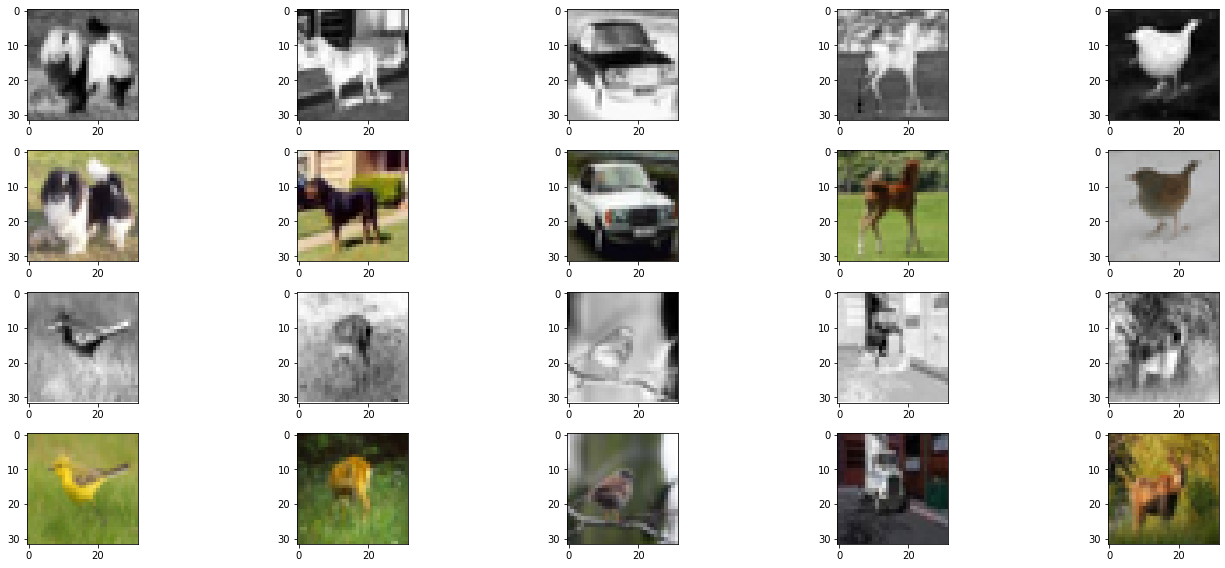

In [25]:
images = []
maximum_val = len(testset) - 1
for i in range(20):
  images.append(randint(0,maximum_val))
fig, ax = plt.subplots(4, 5, figsize=(20, 8))
for i in range(20):
  ax[(i // 10) * 2][i % 5].imshow(trainset[images[i]][0].squeeze(), cmap=plt.cm.binary)
  ax[(i // 10) * 2 + 1][i % 5].imshow(trainset[images[i]][1].permute(1, 2, 0))

plt.tight_layout()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

In [26]:

class Color(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()
    self.a1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)#
    self.a1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)#
    self.a2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)#
    self.a2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)#
    self.a3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)#
    self.a4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)#
    self.a4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)#
    self.middle = nn.Conv2d(512, 1024, kernel_size=3, padding=1)#]
    self.Conv2dT4 = nn.ConvTranspose2d(1024, 512, 3, stride=2, padding=1, output_padding=1)
    self.b1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)#
    self.Conv2dT3 = nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1)
    self.b2 = nn.Conv2d(768, 256, kernel_size=3, padding=1)#
    self.b2 = nn.Conv2d(768, 256, kernel_size=3, padding=1)#
    self.Conv2dT2 = nn.ConvTranspose2d(256, 512, 3, stride=2, padding=1, output_padding=1)
    self.b3 = nn.Conv2d(640, 128, kernel_size=3, padding=1)
    self.b3 = nn.Conv2d(640, 128, kernel_size=3, padding=1)#
    self.Conv2dT1 = nn.ConvTranspose2d(128, 512, 3, stride=2, padding=1, output_padding=1)
    self.b4 = nn.Conv2d(576, 216, kernel_size=3, padding=1)#
    self.b4 = nn.Conv2d(576, 216, kernel_size = 3, padding=1)#
    self.final = nn.Conv2d(216, output_channels, kernel_size=1, padding=0)


  def forward(self, x):
    x = self.a1(x)
    x = nn.ReLU()(x)
    y = nn.MaxPool2d(2)(x)
    y = self.a2(y)
    y = nn.ReLU()(y)
    z = nn.MaxPool2d(2)(y)
    z = self.a3(z)
    z = nn.ReLU()(z)
    t = nn.MaxPool2d(2)(z)
    t = self.a4(t)
    t = nn.ReLU()(t)
    r = nn.MaxPool2d(2)(t)
    r = self.middle(r)
    r = nn.ReLU()(r)
    r = self.Conv2dT4(r)
    r = torch.cat([t, r], dim=1)
    r = self.b1(r)
    r = self.Conv2dT3(r)
    r = torch.cat([z, r], dim=1)
    r = self.b2(r)
    r = self.Conv2dT2(r)
    r = torch.cat([y, r], dim=1)
    r = self.b3(r)
    r = self.Conv2dT1(r)
    r = torch.cat([x, r], dim=1)
    r = self.b4(r)
    r = self.final(r)
    return r

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnet = Color(1, 3).to(device)
cnet = cnet.to(device)

num_params = sum(p.numel() for p in cnet.parameters() if p.requires_grad)
print('Number of params: %d' % (num_params))

Number of params: 23465699


## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [27]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(cnet.parameters(), lr=0.001)
train_loss = []
val_loss = []
def train_epoch(model, criterion, optimizer, dataloader, epoch_num):
    epoch_loss = 0
    
    model.train()
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            yhat = cnet(x)
            
            loss = criterion(yhat, y)
            epoch_loss += float(loss)
            
            predictions = yhat.argmax(-1)
            pbar.set_description(f'Train Loss: {epoch_loss / (i + 1)}')
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    train_loss.append(epoch_loss / len(dataloader))


def eval_epoch(model, criterion, dataloader, epoch_num):
    epoch_loss = 0
    
    model.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            yhat = cnet(x)
            
            loss = criterion(yhat, y)
            epoch_loss += float(loss)

            pbar.set_description(f'Validation Loss: {epoch_loss / (i + 1)}\t')
    
    val_loss.append(epoch_loss / len(dataloader))
epochs = 40

for e in range(epochs):

    start_time =time()

    train_epoch(cnet, criterion, optimizer, train_loader, e + 1)
    eval_epoch(cnet, criterion, val_loader, e + 1)
    end_time = time()
    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

Validation Loss: 0.013326986972242594	: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Epoch   1 finished in 141.43s


Validation Loss: 0.00842616194859147	: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Epoch   2 finished in 140.92s


Validation Loss: 0.006867126608267426	: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


Epoch   3 finished in 140.79s


Validation Loss: 0.0065249405335634945	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch   4 finished in 141.16s


Validation Loss: 0.00638376297429204	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch   5 finished in 141.19s


Validation Loss: 0.006241406640037894	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch   6 finished in 141.10s


Validation Loss: 0.006054357951506972	: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Epoch   7 finished in 141.30s


Validation Loss: 0.005806691804900765	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch   8 finished in 141.24s


Validation Loss: 0.00582812624052167	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch   9 finished in 141.22s


Validation Loss: 0.005641926638782024	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  10 finished in 141.08s


Validation Loss: 0.005589289218187332	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  11 finished in 141.16s


Validation Loss: 0.0055784342344850305	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  12 finished in 141.25s


Validation Loss: 0.005635347170755267	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  13 finished in 141.17s


Validation Loss: 0.005485383234918118	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  14 finished in 141.30s


Validation Loss: 0.005447780620306731	: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Epoch  15 finished in 141.30s


Validation Loss: 0.005555349215865135	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  16 finished in 141.31s


Validation Loss: 0.00539462435990572	: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Epoch  17 finished in 141.27s


Validation Loss: 0.005400461331009865	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  18 finished in 141.06s


Validation Loss: 0.005411085486412048	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  19 finished in 141.04s


Validation Loss: 0.005355110252276063	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  20 finished in 141.22s


Validation Loss: 0.005338769825175405	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  21 finished in 141.20s


Validation Loss: 0.0053163109812885525	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  22 finished in 141.15s


Validation Loss: 0.0053303690627217295	: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Epoch  23 finished in 141.29s


Validation Loss: 0.005318026663735509	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  24 finished in 141.13s


Validation Loss: 0.005345082050189376	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  25 finished in 141.11s


Validation Loss: 0.005323968455195427	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  26 finished in 141.14s


Validation Loss: 0.00533767337910831	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  27 finished in 141.30s


Validation Loss: 0.005328619945794344	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  28 finished in 141.20s


Validation Loss: 0.005397279094904661	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  29 finished in 141.32s


Validation Loss: 0.005277708172798157	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  30 finished in 141.16s


Validation Loss: 0.005262359557673335	: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Epoch  31 finished in 141.26s


Validation Loss: 0.005280181905254722	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  32 finished in 141.10s


Validation Loss: 0.005255444906651974	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  33 finished in 141.07s


Validation Loss: 0.0052318337839096785	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  34 finished in 141.16s


Validation Loss: 0.005340642761439085	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  35 finished in 141.15s


Validation Loss: 0.005248730583116412	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  36 finished in 141.16s


Validation Loss: 0.005221536569297314	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  37 finished in 141.30s


Validation Loss: 0.005235899705439806	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch  38 finished in 141.25s


Validation Loss: 0.005450889328494668	: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Epoch  39 finished in 141.31s


Validation Loss: 0.0052839192561805245	: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

Epoch  40 finished in 141.23s


### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

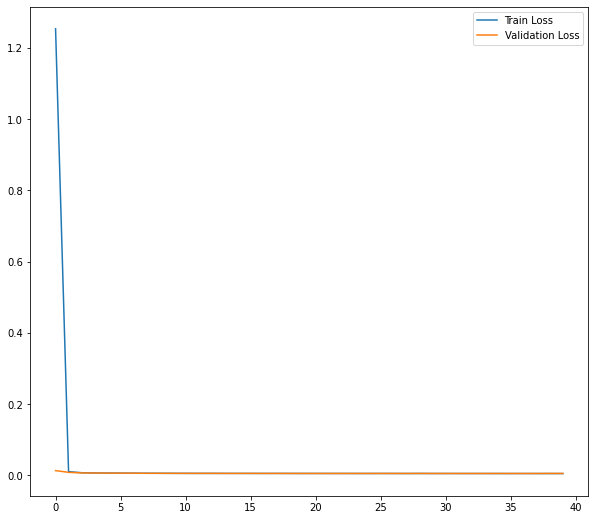

In [28]:
fig, ax, = plt.subplots()
ax.plot(train_loss, label='Train Loss')
ax.plot(val_loss, label='Validation Loss')
ax.legend();

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



[]

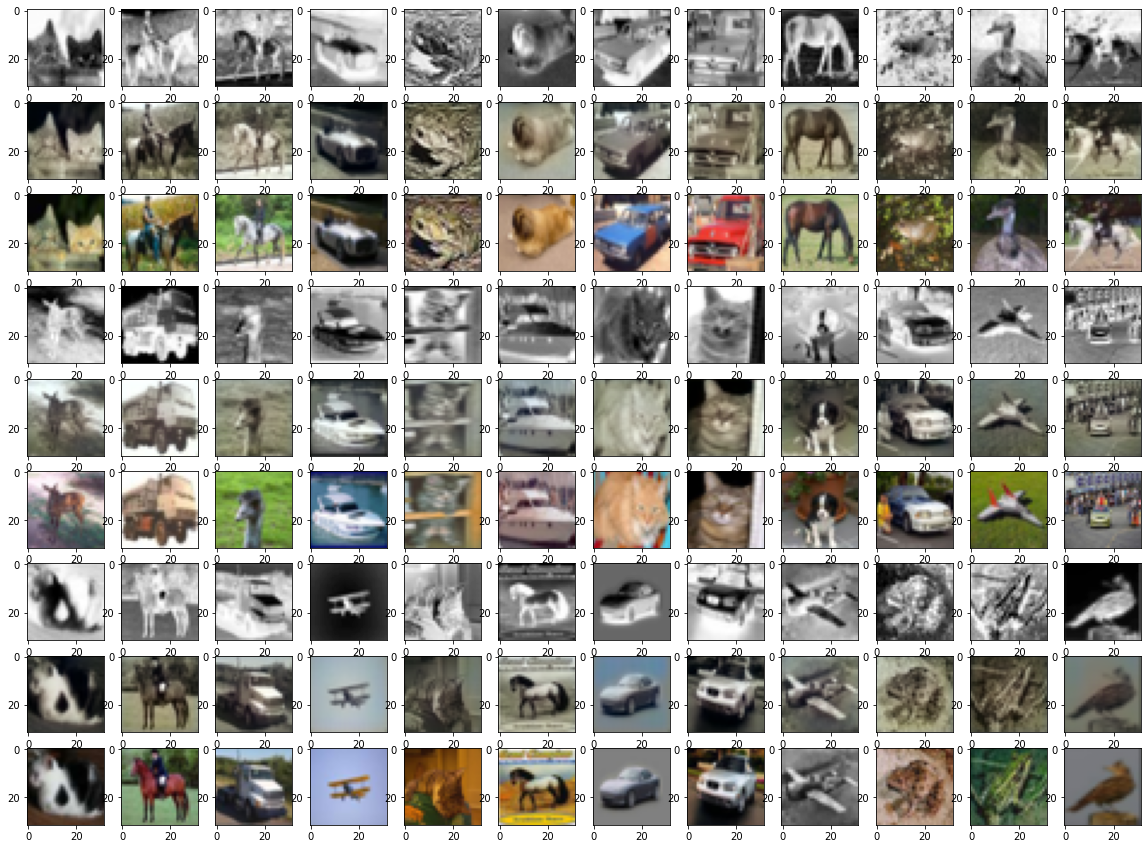

In [29]:

images = []
maximum_val = len(testset) - 1
for i in range(36):
  images.append(randint(0,maximum_val))
fig, ax = plt.subplots(9, 12, figsize=(20, 15))
for i in range(36):
  plt_row = 3 * ( i // 12 )
  plt_col = i % 12
  net = cnet(testset[images[i]][0].reshape(1, 1, 32, 32).to(device))
  ax[plt_row][plt_col].imshow(testset[images[i]][0].squeeze(), cmap=plt.cm.binary)
  ax[plt_row + 1][ plt_col ].imshow(net.cpu().permute(0, 2, 3, 1).detach().numpy().squeeze())
  ax[plt_row + 2][plt_col].imshow(testset[images[i]][1].permute(1, 2, 0))

plt.plot()